In [41]:
import tensorflow as tf
import spacy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
nlp = spacy.load("en_core_web_sm")

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import re
import string

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import re

In [8]:
train = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv',encoding='latin1')
test = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv',encoding='latin1')

In [9]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


## Data Cleaning

In [4]:
nltk.download('stopwords')
nltk.download('punkt')

stop_word = stopwords.words('english')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
import re

def clean(text):
    # remove urls
    text = re.sub(r'http\S+', " ", text)

    # remove mentions
    text = re.sub(r'@\w+', ' ', text)

    # remove hashtags
    text = re.sub(r'#\w+', ' ', text)

    # remove digits
    text = re.sub(r'\d+', ' ', text)

    # remove html tags
    text = re.sub('<.*?>', ' ', text)

    # remove emojis
    emoji_pattern = re.compile("["
            u"\U0001F300-\U0001F5FF"  # symbol maps&country
            u"\U0001F680-\U0001F6FF"  # time & vehicle symbol
            u"\U0001F780-\U0001F7FF"  # kartu & simbol bermain
            u"\U0001F900-\U0001F9FF"  # face emoji 
            u"\U0001FA00-\U0001FA6F"  # sport emoji 
            u"\U0001FA70-\U0001FAFF"  # food emoji 
            "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    #Removal of Punctuation Marks
    def remove_punctuations(text):
        return re.sub('\[[^]]*\]', '', text)

    # Removal of Special Characters
    def remove_characters(text):
        return re.sub("[^a-zA-Z]"," ",text)

    # remove stop words
    text = text.split()
    text = " ".join([word for word in text if not word in stop_word])

    return text

In [11]:
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: clean(x))
test['OriginalTweet'] = test['OriginalTweet'].apply(lambda x: clean(x))

In [12]:
X = train['OriginalTweet']
y = train['Sentiment']

In [13]:
encoding = {'Extremely Negative': 0,
            'Negative': 0,
            'Neutral': 1,
            'Positive':2,
            'Extremely Positive': 2
           }

labels = ['Negative', 'Neutral', 'Positive']


y.replace(encoding, inplace=True)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32925,), (8232,), (32925,), (8232,))

## Tokenizing

In [15]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

In [16]:
# Load pre-trained DistilBERT model and tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [23]:
X_train = X_train.astype(str)
X_test = X_test.astype(str)

In [25]:
# Tokenize and pad the input sequences
max_length = 128  
X_train_tokenized = tokenizer(X_train.tolist(), padding=True, truncation=True, max_length=max_length, return_tensors="tf")
X_test_tokenized = tokenizer(X_test.tolist(), padding=True, truncation=True, max_length=max_length, return_tensors="tf")

In [26]:
X_train_tokenized

{'input_ids': <tf.Tensor: shape=(32925, 128), dtype=int32, numpy=
array([[  101, 12163,  4447, ...,     0,     0,     0],
       [  101,  6634,  1011, ...,     0,     0,     0],
       [  101,  1041,  1011, ...,     0,     0,     0],
       ...,
       [  101,  2074,  7034, ...,     0,     0,     0],
       [  101,  2026,  2564, ...,     0,     0,     0],
       [  101,  8438, 20076, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(32925, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [59]:
def create_model(bert_model, max_len=max_length, learning_rate=1e-5):
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')
    
    # Assuming bert_model is already loaded
    # Modify the indexing here based on the actual structure of the output tuple
    embeddings = bert_model([input_ids, attention_masks])[0]
    

    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)
    
    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)
    
    model.compile(optimizer=opt, loss=loss, metrics=[accuracy])

    return model

In [60]:
# Define bertmodel
bert_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model = create_model(bert_model, learning_rate=1e-5)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [61]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_distil_bert_for_sequenc  TFSequenceClassifierOutput   6695501   ['input_7[0][0]',             
 e_classification_8 (TFDist  (loss=None, logits=(None,    0          'input_8[0][0]']             
 ilBertForSequenceClassific  2),                                                                  
 ation)                       hidden_states=None, atten                                     

## Model Training

In [62]:
# Define callback for model checkpoint
model_checkpoint_callback = ModelCheckpoint(
    filepath='best_model_distilbert.h5',
    save_best_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    verbose=1
)

# Define callback for early stopping
early_stopping_callback = EarlyStopping(
    patience=5,
    monitor='val_categorical_accuracy',
    mode='max',
    restore_best_weights=True,
    verbose=1
)

In [63]:
y_train.unique()

array([0, 1, 2])

In [64]:
# Training
history = model.fit(
    [X_train_tokenized['input_ids'], X_train_tokenized['attention_mask']],
    y_train,
    epochs=20,  
    batch_size=32,
    validation_split=0.2,
    callbacks=[model_checkpoint_callback, early_stopping_callback]
)

Epoch 1/20
824/824 [==============================] - ETA: 0s - loss: 0.6626 - categorical_accuracy: 0.3606
Epoch 1: val_categorical_accuracy improved from -inf to 0.36477, saving model to best_model_distilbert.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


824/824 [==============================] - 373s 424ms/step - loss: 0.6626 - categorical_accuracy: 0.3606 - val_loss: 0.4612 - val_categorical_accuracy: 0.3648
Epoch 2/20
824/824 [==============================] - ETA: 0s - loss: 0.4043 - categorical_accuracy: 0.3873
Epoch 2: val_categorical_accuracy improved from 0.36477 to 0.39195, saving model to best_model_distilbert.h5
824/824 [==============================] - 346s 420ms/step - loss: 0.4043 - categorical_accuracy: 0.3873 - val_loss: 0.3820 - val_categorical_accuracy: 0.3920
Epoch 3/20
824/824 [==============================] - ETA: 0s - loss: 0.3059 - categorical_accuracy: 0.3835
Epoch 3: val_categorical_accuracy improved from 0.39195 to 0.42111, saving model to best_model_distilbert.h5
824/824 [==============================] - 346s 420ms/step - loss: 0.3059 - categorical_accuracy: 0.3835 - val_loss: 0.3661 - val_categorical_accuracy: 0.4211
Epoch 4/20
824/824 [==============================] - ETA: 0s - loss: 0.2461 - categorica

In [65]:
# Evaluating the model
loss, accuracy = model.evaluate(
    [X_test_tokenized['input_ids'], X_test_tokenized['attention_mask']],
    y_test
)
print(f'Accuracy on test set: {accuracy * 100:.2f}%')

258/258 [==============================] - 36s 138ms/step - loss: 0.3947 - categorical_accuracy: 0.4210
Accuracy on test set: 42.10%


258/258 [==============================] - 36s 134ms/step


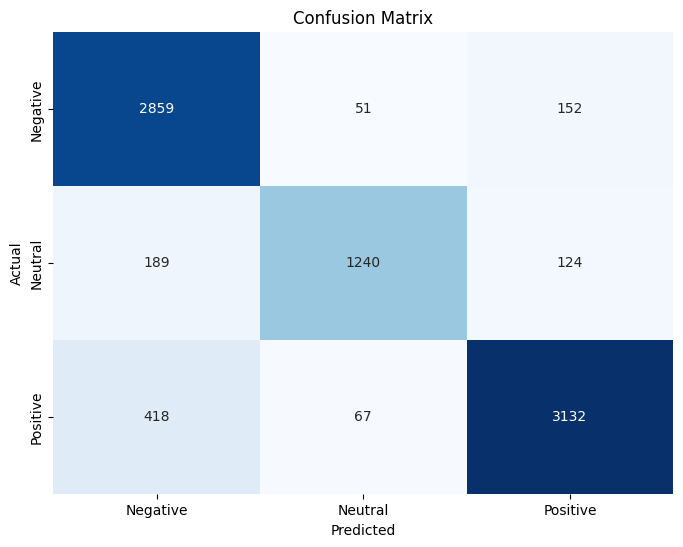

In [66]:
# Predict
y_pred = model.predict([X_test_tokenized['input_ids'], X_test_tokenized['attention_mask']])
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [67]:
# Classification Report
class_report = classification_report(y_test, y_pred_classes)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.93      0.88      3062
           1       0.91      0.80      0.85      1553
           2       0.92      0.87      0.89      3617

    accuracy                           0.88      8232
   macro avg       0.89      0.87      0.87      8232
weighted avg       0.88      0.88      0.88      8232

